# Game, Clock, Guess
### Predicting Tennis Match Length Based on Player Rank Difference

By Group 29 of section 007

<img src="https://www.atptour.com/-/media/images/news/2022/11/24/21/58/alcaraz-sinner-best-of-2022-grand-slam-matches.jpg"/> 

## Introduction

In tennis, a unique aspect of the game is the duration of the matches. The average men’s tennis matches last between 1.5 to 5 hours. The unpredictability within the sport allows for what was expected to be a quick match to suddenly become lengthy. The expectancy that one has, comes from the tennis players’ rankings. For professional men’s tennis, there’s the Association of Tennis Professionals (ATP): a point system based on the tennis season. The points given depend on the tournament’s difficulty. Tournaments known as “Grand Slams” are given more points compared to tournaments like ATP Tour Masters. A player gains more points when they win. There’s a correlation between tennis player rankings and the length of the tennis match, as one may believe when there’s a greater rank difference between players, the tennis match length is shorter - hence why earlier tournament rounds have shorter match length averages. It’s important to understand the correlation to better manage the tournament regarding the match scheduling. One could ask: based on the difference in rank between the winner and loser of a tennis match, and we predict the length of a game? This correlation also helps within a player’s performance analysis to see who and when a player dominates throughout their matches - a statistic for coaches, players, and fans to have a deeper understanding of the game dynamics. In order to display this correlation, the dataset used displays the Men’s ATP tennis matches through 2017 - 2019, specifically looking at the winner and loser ranks, rank differences, and match length for each match within each tournament. This dataset allows us to visualize the correlation between tennis rankings and match lengths. 


## Preliminary Exploratory Data Analysis

In [5]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)
source('tests.R')
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [62]:
#reading the dataset
game <- read_csv("game_results.csv")
game

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2881,2017-0605,Tour Finals,Hard,8,F,20171113,300,105777,6.0,⋯,54,42,22,15,11,15,6,3650,8,2975
2882,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,1,105676,NA,⋯,53,33,21,14,6,11,7,3775,18,2235
2883,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,2,104542,NA,⋯,54,30,12,12,5,11,15,2320,76,667


In [66]:
#wrangling and summarizing the data

#splitting the dataset into training and testing data
game_split <- initial_split(game, prop = 0.75, strata = minutes)
game_training <- training(game_split)
game_testing <- testing(game_split)

#selected and created the necessary columns and arranged by descending rank difference while removing hour and rank_diff rows with NA values
transformed_game<- select(game_training, tourney_name, winner_rank, loser_rank, minutes) |>
                    mutate(hours = minutes/60, rank_diff = loser_rank - winner_rank) |>
                    arrange(desc(rank_diff)) |>
                    drop_na(hours, rank_diff)
transformed_game

tourney_name,winner_rank,loser_rank,minutes,hours,rank_diff
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rio De Janeiro,6,1821,36,0.6000000,1815
Quito,135,1753,142,2.3666667,1618
Pune,113,1690,150,2.5000000,1577
Davis Cup G2 R1: FIN vs GEO,89,1511,110,1.8333333,1422
Marseille,129,1341,59,0.9833333,1212
⋮,⋮,⋮,⋮,⋮,⋮
Wimbledon,589,32,173,2.883333,-557
Queen's Club,698,6,121,2.016667,-692
Washington,832,93,182,3.033333,-739


tourney_name,winner_rank,loser_rank,minutes,hours,rank_diff
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cincinnati Masters,77,49,143,2.3833333,-28
Davis Cup Finals RR: USA vs ITA,12,36,112,1.8666667,24
Miami Masters,19,65,93,1.5500000,46
Paris Masters,55,32,56,0.9333333,-23
Shanghai Masters,47,46,83,1.3833333,-1
⋮,⋮,⋮,⋮,⋮,⋮
Basel,64,52,77,1.283333,-12
Rome Masters,7,4,111,1.850000,-3
Roland Garros,11,69,197,3.283333,58


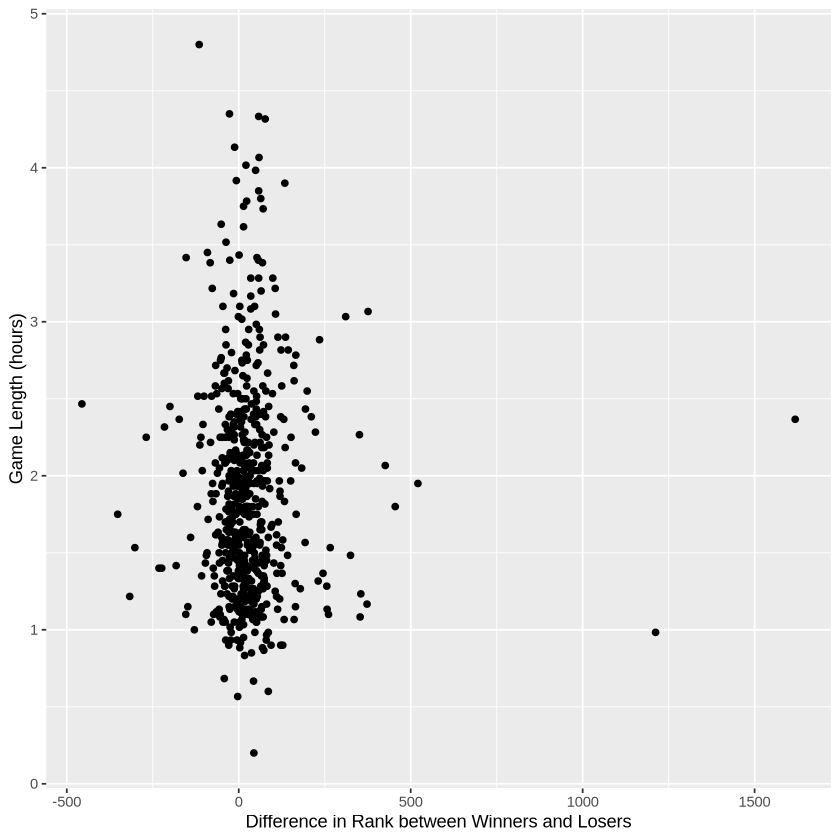

In [68]:
#selecting 600 random samples out of the thousands or so present in the training set
game_samples <- transformed_game |>
                sample_n(600)

#visualizing the data
game_plot_hours <- game_samples |>
                ggplot(aes(x = rank_diff, y = hours)) +
                geom_point() +
                xlab("Difference in Rank between Winners and Losers") +
                ylab("Game Length (hours)")
game_samples
game_plot_hours

## Methods

In order to conduct our data analysis, we are focusing on regression. A regression model predicts a new observation’s response variable based on the response variables for similar observations in the data set of past observations. From the data set, `atp2017-2019.csv` (renamed to be `game_results.csv` for this notebook) we are using the `winner_rank` column and the `loser_rank` column in order to find the difference between the two. Additionally, we are also using the column `minutes` in order to see the length of matches. In order to predict the length of a match based on individual rank, we are choosing to visualize our data analysis using the ggplot function to create scatter plots comparing the Difference of Rank between Winners and Losers of Matches (x-axis) and Game Length in Hours (y-axis). By visualizing our chosen data, it will allow us to examine the trends/patterns. To take a closer look at the trends within the data, we will be using a sample of about 600 randomized matches throughout 2017 and 2019 to see the correlation. 

## Expected Outcomes

After completing a data analysis to research the question: "based on the difference in rank between the winner and loser of a tennis match, can we predict the length of a game?", we expect to see that the closer in rank two players are (i.e. rank difference close to 0), then the match will be longer and vice versa for those that have a greater rank difference throughout all the tournaments. We expect to find this trend based on the background research conducted. As such, these findings could have an impact as this data can be used to analyze a player’s match depending on the tournaments attended to see where the player did better. Furthermore, we hope that this could lead us to ask future questions, such as: "What is the probability of a longer match to occur with two players with a larger rank difference in tennis?", which could be found by looking through the outliers in our dataset. 



In [33]:
source("cleanup.R")

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection
